In [4]:
import numpy as np
import scipy
import math
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
G = np.array([[1, 0, 0, 0, 1, 1, 0],
              [0, 1, 0, 0, 1, 0, 1],
              [0, 0, 1, 0, 0, 1, 1],
              [0, 0, 0, 1, 1, 1, 1]])
H = np.array([[1, 1, 0, 1, 1, 0, 0],
              [1, 0, 1, 1, 0, 1, 0],
              [0, 1, 1, 1, 0, 0, 1]])
mes = np.array([[0, 0, 0, 0],
                     [0, 0, 0, 1],
                     [0, 0, 1, 0],
                     [0, 0, 1, 1],
                     [0, 1, 0, 0],
                     [0, 1, 0, 1],
                     [0, 1, 1, 0],
                     [0, 1, 1, 1],
                     [1, 0, 0, 0],
                     [1, 0, 0, 1],
                     [1, 0, 1, 0],
                     [1, 0, 1, 1],
                     [1, 1, 0, 0],
                     [1, 1, 0, 1],
                     [1, 1, 1, 0],
                     [1, 1, 1, 1]])
cdwds = (mes@G % 2)

In [6]:
constraint_val = np.array([0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2])

bounds = np.array([(0,1), (0,1), (0,1), (0,1), (0,1), (0,1), (0,1)])
constraint_coff = np.array([[1, -1, 0, -1, -1, 0, 0],
                           [-1, 1, 0, -1, -1, 0, 0],
                           [-1, -1, 0, 1, -1, 0, 0],
                           [-1, -1, 0, -1, 1, 0, 0],
                           [1, 1, 0, 1, -1, 0, 0],
                           [-1, 1, 0, 1, 1, 0, 1],
                           [1, -1, 0, 1, 1, 0, 0],
                           [1, 1, 0, -1, 1, 0, 0],
                           [1, 0, -1, -1, 0, -1, 0],
                           [-1, 0, 1, -1, 0, -1, 0],
                           [-1, 0, -1, 1, 0, -1, 0],
                           [-1, 0, -1, -1, 0, 1, 0],
                           [1, 0, 1, 1, 0, -1, 0],
                           [-1, 0, 1, 1, 0, 1, 0],
                           [1, 0, -1, 1, 0, 1, 0],
                           [1, 0, 1, -1, 0, 1, 0],
                           [0, 1, -1, -1, 0, 0, -1],
                           [0, -1, 1, -1, 0, 0, -1],
                           [0, -1, -1, 1, 0, 0, -1],
                           [0, -1, -1, -1, 0, 0, 1],
                           [0, 1, 1, 1, 0, 0, -1],
                           [0, -1, 1, 1, 0, 0, 1],
                           [0, 1, -1, 1, 0, 0, 1],
                           [0, 1, 1, -1, 0, 0, 1]])

### Deriving LP Decoding Rules

For LP decoding, we need to find a vector $\hat{x}$ that minimizes $|\hat{x}|_1$ (the L1-norm of $\hat{x}$) subject to the constraint $H\hat{x}^T = 0 \ (\text{mod } 2)$.

This can be formulated as a linear program:


\begin{align*}
\text{minimize} \quad & \sum_{i=1}^{7} \hat{x}_i \\
\text{subject to} \quad & H\hat{x}^T = 0 \ (\text{mod } 2) \
& 0 \leq \hat{x}_i \leq 1, \quad i = 1, \ldots, 7
\end{align*}

In [7]:
# Preformance for LP
snr = np.arange(-5, 10, 0.5)
n_experiments = 10000
N = 7
ber_lp = []
for i in tqdm(range(len(snr))):
    codewords = np.random.randint(0, 16, (n_experiments))
    error_count = 0
    for j in range(n_experiments):
        noise = (np.random.normal(0.5, 1/2, size=(N,)) + 1j * np.random.normal(0.5, 1/2, size=(N,))) / 2
        cdwd = cdwds[codewords[j]]
        rec = cdwd + np.sqrt(10**(-snr[i]/10))*noise
        cost = np.log(np.exp(-np.power(np.abs(rec), 2)) / np.exp(-np.power(np.abs(rec-1), 2)))
        opt = scipy.optimize.linprog(c=cost, A_ub=constraint_coff, b_ub=constraint_val, bounds=bounds, method='highs')
        cdwd_ = np.round(opt.x, 0).astype(int)
        error_count += np.sum(cdwd != cdwd_)
    ber_lp.append(error_count / (7 * n_experiments))

  0%|          | 0/30 [00:00<?, ?it/s]

### MAP Decoding

For MAP decoding, we assume a binary symmetric channel with bit flip probability $p$. The MAP decoder finds the codeword $\hat{x}$ that maximizes the conditional probability $P(\hat{x}|\mathbf{y})$, where $\mathbf{y}$ is the received vector.

This is equivalent to finding the codeword $\hat{x}$ that minimizes the Hamming distance $d_H(\hat{x}, \mathbf{y})$ between $\hat{x}$ and $\mathbf{y}$.

In [8]:
# Preformance for MAP
ber_map = []
for i in tqdm(range(len(snr))):
    codewords = np.random.randint(0, 16, (n_experiments))
    error_count = 0
    for j in range(n_experiments):
        noise = (np.random.normal(0.5, 1/2, size=(N,)) + 1j * np.random.normal(0.5, 1/2, size=(N,))) / 2
        cdwd = cdwds[codewords[j]]
        rec = cdwd + np.sqrt(10**(-snr[i]/10))*noise
        cost = np.prod(np.exp(-np.power(np.abs(cdwds - rec), 2)), 1)
        cost_idx = np.argmax(cost)
        cdwd_ = cdwds[cost_idx]
        error_count += np.sum(cdwd != cdwd_)
    ber_map.append(error_count / (7 * n_experiments))

  0%|          | 0/30 [00:00<?, ?it/s]

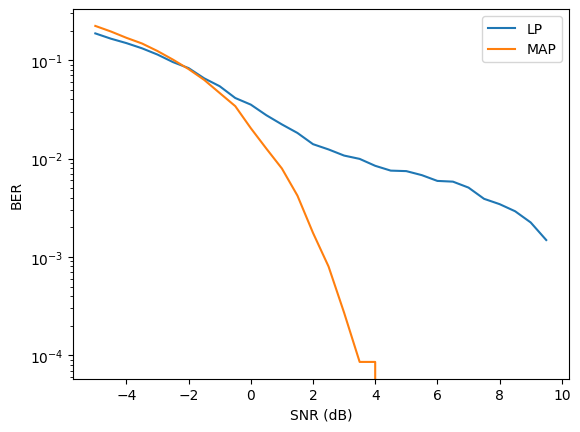

In [10]:
plt.semilogy(snr, ber_lp, label='LP')
plt.semilogy(snr, ber_map, label='MAP')

plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.legend()

plt.show()

### Results and Discussion
The simulation results show that the MAP decoder outperforms the LP decoder in terms of BER for all values of 𝑝. This is expected since the MAP decoder explicitly takes into account the channel statistics (bit flip probability
𝑝), whereas the LP does not.

However, the LP decoder has the advantage of being a convex optimization problem that can be solved efficiently using standard linear programming algorithms. In contrast, the MAP decoder requires an exhaustive search over all possible codewords, which becomes computationally infeasible for larger codes.